In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [3]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids


### Import CSV and Perform Data Cleaning

In [4]:
# imprt CSV as DataFrame
obs_df = pd.read_csv('../Tables/updated_obs_studies.csv')

In [5]:
# Drop 'target_duration' column due to too many null values
# Drop null rows

obs_df = obs_df.drop(['target_duration'], axis=1)
obs_df = obs_df.dropna()
obs_df.head()

,ID,title,actual_duration,status,study_type,observational_study_model,sampling_method,fda_regulated_drug,fda_regulated_device,enrollment_count
0,BTX-BCI-016-PRT,Breast Cancer Index (BCI) Registry,7.638356,Recruiting,Observational,Case-Only,Non-Probability Sample,No,No,3000
1,2018-TJ-BCD,Diagnosis Value of SEMA4C in Breast Cancer,1.002740,Not yet recruiting,Observational,Case-Control,Non-Probability Sample,No,No,2300
2,Breast cancer,Role of Sorcin and Annexin A3 in Breast Cancer...,0.693151,Unknown status,Observational,Case-Control,Probability Sample,No,No,80
3,BC-BOMET,Evaluation of Prognostic Factors: From Breast ...,4.835616,Recruiting,Observational,Case-Control,Non-Probability Sample,No,No,30
4,241391,A Study to Identify Breast Cancer (IDBC),3.936986,Unknown status,Observational,Cohort,Non-Probability Sample,No,No,600


In [6]:
# Check distribution of each status
obs_df.groupby('status').size()

status
Active, not recruiting      75
Completed                  186
Enrolling by invitation     22
Not yet recruiting         126
Recruiting                 446
Suspended                    7
Terminated                  16
Unknown status             127
Withdrawn                   16
dtype: int64

In [7]:
# Drop rows with 'unknown status'
obs_df = obs_df.loc[obs_df['status'] != 'Unknown status']

# categorize the status
replace_value = {
    'Completed':'high_chance',
    'Active, not recruiting': 'low_chance',
    'Enrolling by invitation': 'high_chance',
    'Not yet recruiting': 'low_chance',
    'Recruiting': 'high_chance',
    'Suspended': 'low_chance',
    'Terminated': 'low_chance',
    'Withdrawn': 'low_chance'
} 

obs_df = obs_df.replace({"status": replace_value})
obs_df.head()


,ID,title,actual_duration,status,study_type,observational_study_model,sampling_method,fda_regulated_drug,fda_regulated_device,enrollment_count
0,BTX-BCI-016-PRT,Breast Cancer Index (BCI) Registry,7.638356,high_chance,Observational,Case-Only,Non-Probability Sample,No,No,3000
1,2018-TJ-BCD,Diagnosis Value of SEMA4C in Breast Cancer,1.002740,low_chance,Observational,Case-Control,Non-Probability Sample,No,No,2300
3,BC-BOMET,Evaluation of Prognostic Factors: From Breast ...,4.835616,high_chance,Observational,Case-Control,Non-Probability Sample,No,No,30
6,FH-Risk 2.0 Research Protocol,FH-Risk 2.0: Updating Breast Cancer Risk Estim...,2.671233,high_chance,Observational,Other,Non-Probability Sample,No,No,271
7,ID-RPSBC-01-20201012,Genetic and Non-Genetic Breast Cancer Risk Pre...,2.712329,high_chance,Observational,Case-Control,Probability Sample,No,No,316


In [8]:
# Create DF for machine learning - removes unnecessary columns
obs_ml_df = obs_df[['status', 'enrollment_count', 'actual_duration', 'observational_study_model', 'sampling_method', 'fda_regulated_drug', 'fda_regulated_device', ]]

In [9]:
# Encode all columns into numbers to run through machine learning
obs_ml_df['status'] = LabelEncoder().fit_transform(obs_ml_df['status'])
obs_ml_df = pd.get_dummies(obs_ml_df,columns=['observational_study_model', 'sampling_method', 'fda_regulated_drug', 'fda_regulated_device'])
obs_ml_df.head()

,status,enrollment_count,actual_duration,observational_study_model_Case-Control,observational_study_model_Case-Crossover,observational_study_model_Case-Only,observational_study_model_Cohort,observational_study_model_Ecologic or Community,observational_study_model_Family-Based,observational_study_model_Other,sampling_method_Non-Probability Sample,sampling_method_Probability Sample,fda_regulated_drug_No,fda_regulated_drug_Yes,fda_regulated_device_No,fda_regulated_device_Yes
0,0,3000,7.638356,0,0,1,0,0,0,0,1,0,1,0,1,0
1,1,2300,1.002740,1,0,0,0,0,0,0,1,0,1,0,1,0
3,0,30,4.835616,1,0,0,0,0,0,0,1,0,1,0,1,0
6,0,271,2.671233,0,0,0,0,0,0,1,1,0,1,0,1,0
7,0,316,2.712329,1,0,0,0,0,0,0,0,1,1,0,1,0


In [10]:
X = obs_ml_df.drop("status", axis=1)
y = obs_ml_df.status

In [11]:
# Split to test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create StandardScaler instance
scaler = StandardScaler()

# Fit Standard Scaler with training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Random Forest Classifier

In [12]:
# Create random forest classifier
rf_model = RandomForestClassifier(n_estimators=256, random_state=1)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Create prediction
y_pred = rf_model.predict(X_test_scaled)

In [13]:
# Define printing results for machine learning
def print_result(model):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual High Chance', 'Actual Low chance'], columns = ['Predicted High Chance', 'Predicted Low Chance'])

    # Calculate accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)

    # Print results
    print(model + " Results\n")
    print("Confusion Matrix")
    display(cm_df)
    print(f'Accuracy Score: {acc_score}')
    print(f'Balanced Accuracy Score: {bal_acc_score}')
    print("---------------------------")
    print("Classfication Report")
    print(classification_report_imbalanced(y_test, y_pred))


In [14]:
print_result("Random Forest Classifier")

Random Forest Classifier Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,148,22
Actual Low chance,38,16


Accuracy Score: 0.7321428571428571
Balanced Accuracy Score: 0.583442265795207
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.87      0.30      0.83      0.51      0.27       170
          1       0.42      0.30      0.87      0.35      0.51      0.24        54

avg / total       0.71      0.73      0.43      0.71      0.51      0.27       224



In [15]:
# Calculate feature importance
rf_importances = rf_model.feature_importances_

# sort features by importance
sorted(zip(rf_importances, X.columns), reverse=True)

[(0.4681344902908242, 'actual_duration'),
 (0.4400525697525509, 'enrollment_count'),
 (0.011902048343715348, 'observational_study_model_Cohort'),
 (0.011274738340037753, 'sampling_method_Non-Probability Sample'),
 (0.010232426946997044, 'observational_study_model_Case-Control'),
 (0.009894184254706196, 'observational_study_model_Other'),
 (0.008942864520079407, 'sampling_method_Probability Sample'),
 (0.008363739362938055, 'observational_study_model_Case-Only'),
 (0.005958669580013565, 'fda_regulated_drug_No'),
 (0.005718676244156647, 'observational_study_model_Case-Crossover'),
 (0.005631067142487108, 'fda_regulated_drug_Yes'),
 (0.005481794395934248, 'fda_regulated_device_Yes'),
 (0.005013603106586491, 'fda_regulated_device_No'),
 (0.0024176150111368476, 'observational_study_model_Ecologic or Community'),
 (0.000981512707836105, 'observational_study_model_Family-Based')]

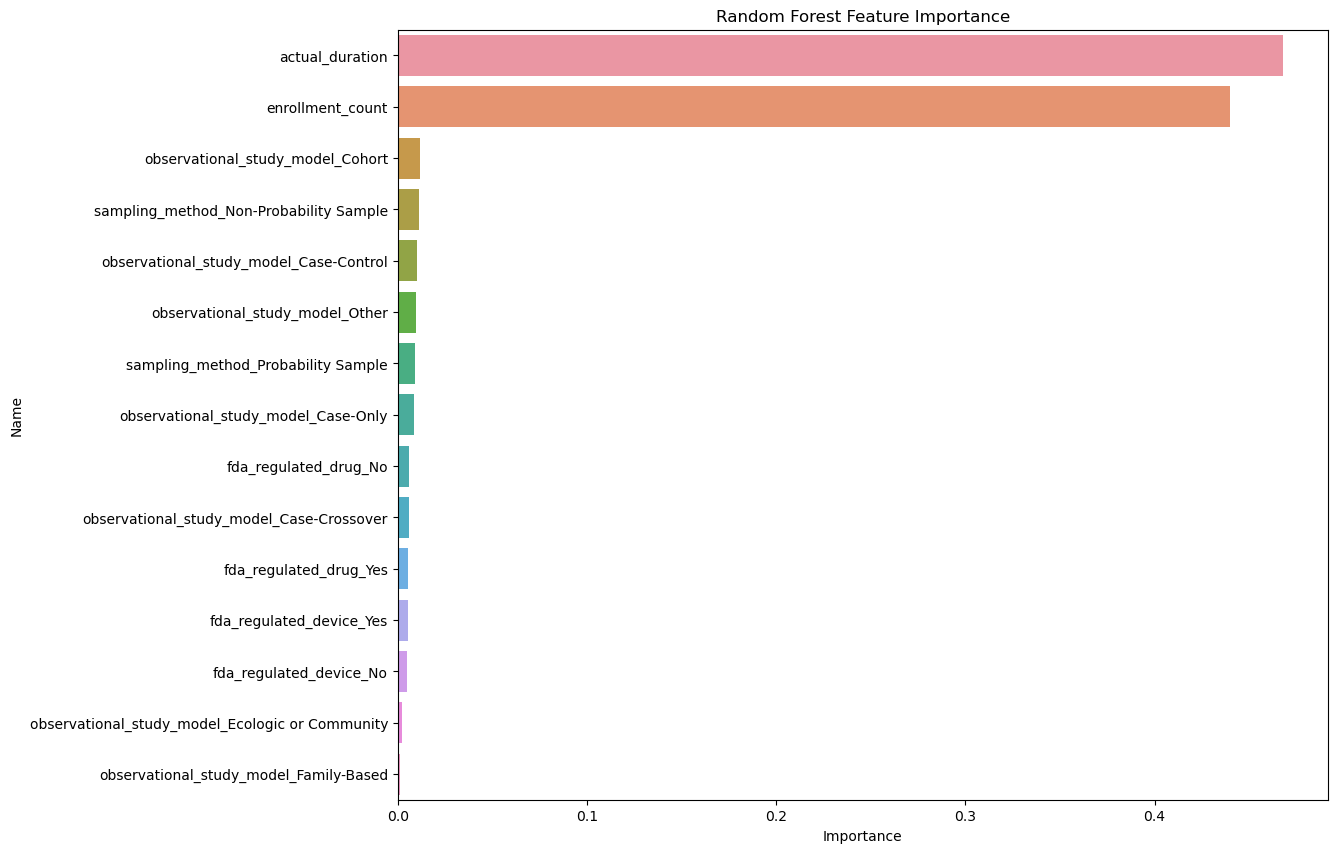

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# define function to plot feature importance
def plot_importance (importance, names, model_type):

    df = pd.DataFrame({'Names':names, 'Importance':importance})
    df.sort_values(by=['Importance'], ascending=False, inplace=True)

    plt.figure(figsize=(12,10))
    sns.barplot(x=df['Importance'], y=df['Names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Name')

    plt.show()

plot_importance(rf_importances, X.columns, 'Random Forest')

### Balanced Random Forest Classifier

In [17]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate model
brf_classifier = BalancedRandomForestClassifier(n_estimators=256, random_state=1)

# Fit model
brf_classifier.fit(X_train_scaled, y_train)

# Create prediction
y_pred = brf_classifier.predict(X_test_scaled)

In [18]:
print_result("Balanced Random Forest Classifer")

Balanced Random Forest Classifer Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,91,79
Actual Low chance,22,32


Accuracy Score: 0.5491071428571429
Balanced Accuracy Score: 0.5639433551198256
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.54      0.59      0.64      0.56      0.32       170
          1       0.29      0.59      0.54      0.39      0.56      0.32        54

avg / total       0.68      0.55      0.58      0.58      0.56      0.32       224



In [19]:
# Calculate feature importance
brf_importances = brf_classifier.feature_importances_

# List the features sorted in descending order by feature importance
features_rank = sorted(zip(brf_importances, X.columns), reverse=True)
for feature in features_rank:
    print(f"{feature[1]}: ({feature[0]})")

actual_duration: (0.45317556142022075)
enrollment_count: (0.4225056608215723)
observational_study_model_Cohort: (0.015825957367004193)
sampling_method_Probability Sample: (0.014224299692666413)
observational_study_model_Case-Control: (0.013822897582651043)
observational_study_model_Case-Only: (0.013231747642086324)
sampling_method_Non-Probability Sample: (0.01312183989371171)
observational_study_model_Other: (0.011487187208082821)
fda_regulated_device_Yes: (0.00843763462751591)
fda_regulated_drug_No: (0.008278011168463075)
fda_regulated_drug_Yes: (0.007564905215675407)
fda_regulated_device_No: (0.00739665558992557)
observational_study_model_Case-Crossover: (0.005797732906257477)
observational_study_model_Ecologic or Community: (0.003575600879360369)
observational_study_model_Family-Based: (0.001554307984806749)


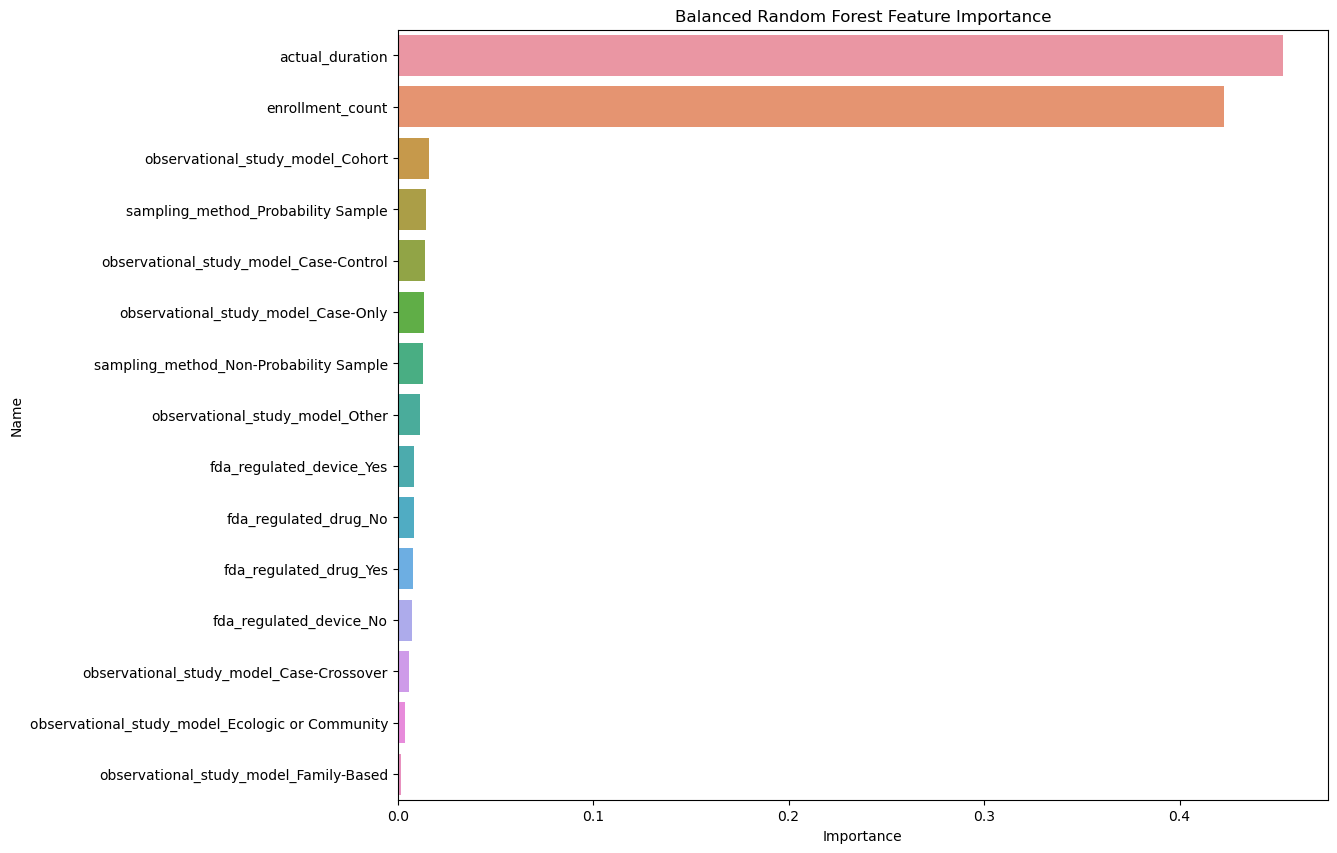

In [20]:
plot_importance(brf_importances, X.columns, 'Balanced Random Forest')

### Logistic Regression

In [21]:
# Declare model
lr_model = LogisticRegression(solver='lbfgs', random_state=42)

# fit the model
lr_model = lr_model.fit(X_train_scaled, y_train)

# create prediction
y_pred = lr_model.predict(X_test_scaled)

In [22]:
print_result("Logistic Regression")

Logistic Regression Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,170,0
Actual Low chance,53,1


Accuracy Score: 0.7633928571428571
Balanced Accuracy Score: 0.5092592592592593
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      1.00      0.02      0.87      0.14      0.02       170
          1       1.00      0.02      1.00      0.04      0.14      0.02        54

avg / total       0.82      0.76      0.26      0.67      0.14      0.02       224



### Optimize model, Use resampling techniques to determine the best performing algorithm

#### Oversampling

- Random Over Sampler

In [23]:
# Define function to re-run machine learning through resampling models

def resample_ml(model):
    classifier = LogisticRegression(solver='lbfgs', random_state=1)
    X_resampled, y_resampled = model.fit_resample(X_train_scaled, y_train)
    classifier.fit(X_resampled, y_resampled)
    y_pred = classifier.predict(X_test)
    

In [24]:
resample_ml(RandomOverSampler(random_state=1))

In [25]:
print_result("Random Over Sampling")

Random Over Sampling Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,170,0
Actual Low chance,53,1


Accuracy Score: 0.7633928571428571
Balanced Accuracy Score: 0.5092592592592593
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      1.00      0.02      0.87      0.14      0.02       170
          1       1.00      0.02      1.00      0.04      0.14      0.02        54

avg / total       0.82      0.76      0.26      0.67      0.14      0.02       224



- SMOTE

In [26]:
resample_ml(SMOTE(random_state=1))

In [27]:
print_result("SMOTE")

SMOTE Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,170,0
Actual Low chance,53,1


Accuracy Score: 0.7633928571428571
Balanced Accuracy Score: 0.5092592592592593
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      1.00      0.02      0.87      0.14      0.02       170
          1       1.00      0.02      1.00      0.04      0.14      0.02        54

avg / total       0.82      0.76      0.26      0.67      0.14      0.02       224



#### Undersampling

In [28]:
# Resample the data using the ClusterCentroids resampler
resample_ml(ClusterCentroids(random_state=1))

In [29]:
print_result("Cluster Centroids")

Cluster Centroids Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,170,0
Actual Low chance,53,1


Accuracy Score: 0.7633928571428571
Balanced Accuracy Score: 0.5092592592592593
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      1.00      0.02      0.87      0.14      0.02       170
          1       1.00      0.02      1.00      0.04      0.14      0.02        54

avg / total       0.82      0.76      0.26      0.67      0.14      0.02       224



#### Combination (Over and Under) Sampling

In [30]:
# Resample using SMOTEENN
resample_ml(SMOTEENN(random_state=1))

In [31]:
print_result("SMOTEENN")

SMOTEENN Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,170,0
Actual Low chance,53,1


Accuracy Score: 0.7633928571428571
Balanced Accuracy Score: 0.5092592592592593
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      1.00      0.02      0.87      0.14      0.02       170
          1       1.00      0.02      1.00      0.04      0.14      0.02        54

avg / total       0.82      0.76      0.26      0.67      0.14      0.02       224

